# NetPyNE Tutorial 8: Grid Parameter Search

## Preliminaries

If you are going to run this notebook locally using Jupyter Notebook, start from following instructions https://github.com/suny-downstate-medical-center/netpyne/blob/development/netpyne/tutorials/README.md.

If you are using Open Source Brain or EBRAINS, everything is already set up.

On any other online platform (e.g. on Google Collab) you might need to run the following commmands to install NEURON and NetPyNE using **pip**:
```
!pip install neuron
!pip install netpyne
```



Code in this tutorial provides the set up of batch simulation itself, while the network paramters and default configuration of individual simulations are provided in separate files in `batch_grid_tut` folder. In summary, `netParams.py` for fixed (network) parameters, `cfg.py` for variable (simulation) parameters, `init.py` to run a simulation, and `analysis.py` to read simulation results and plot them. We will change to this folder. The results will be saved there as well.

In [1]:
import os

os.chdir(os.getcwd() + "/tut_batch_grid")

Lets say we want to explore how the connection weight and the synaptic decay time constant affect the firing rate of the motor population. For this purpose, this parameters in [netParams.py](tut_batch_grid/netParams.py) made variable, i.e. different in each simulation. Instead of having fixed values (e.g. 5.0 and 0.01), they depend on a variable from simConfig: `cfg.synMechTau2` and `cfg.connWeight`.

Note that these two variables to the [cfg.py](tut_batch_grid/cfg.py) so that they exist and can be used by netParams and modified in the batch simulation.

The first thing we do is create an ordered dictionary `params` – this will be of a special NetPyNE type (`specs.ODict`) but it essentially behaves like an ordered dictionary. Next we add the parameters to explore as keys of this dictionary – `synMechTau2` and `connWeight` – and add the list of parameter values to try in the batch simulation as the dictionary keys – [3.0, 5.0, 7.0] and [0.005, 0.01, 0.15]. **Note that parameter names should coincide with the variables defined in `cfg`**.

In [2]:
from netpyne import specs

# Create variable of type ordered dictionary (NetPyNE's customized version)
params = specs.ODict()

# fill in with parameters to explore and range of values (key has to coincide with a variable in simConfig)
params["synMechTau2"] = [3.0, 5.0, 7.0]
params["connWeight"] = [0.005, 0.01, 0.15]

--No graphics will be displayed.


We then create an object `b` of the NetPyNE class `Batch` and pass as arguments the parameters to explore, and the files containing the netParams and simConfig modules. Finally, we customize some attributes of the `Batch` object, including the the batch label (`'tauWeight'`), used to create the output file; the folder where to save the data (`'data'`), the method used to explore parameters (`'grid'`), meaning all combinations of the parameter values; and the run configuration indicating we want to use `'mpi'` (this uses MPI and NEURON’s Bulletin Board; other options are available for supercomputers), the `'init.py'` to run each sims, and to `'skip'` runs if the output files already exist.

At the end we just need to add the command to launch the batch simulation: `b.run()`.

In [3]:
from netpyne.batch import Batch

# create Batch object with parameters to modify, and specifying files to use
b = Batch(
    params=params,
    cfgFile="cfg.py",
    netParamsFile="netParams.py",
)

# Set output folder, grid method (all param combinations), and run configuration
b.batchLabel = "tauWeight"
b.saveFolder = "data"
b.method = "grid"
b.runCfg = {"type": "mpi_bulletin", "script": "init.py", "skip": True}

# Run batch simulations
b.run()

Saving batch to data/tauWeight_batch.json ... 
(0, 0) (3.0, 0.005)
synMechTau2 = 3.0
connWeight = 0.005
Saving simConfig to data/tauWeight_0_0_cfg.json ... 
Submitting job  data/tauWeight_0_0
Saving output to:  data/tauWeight_0_0.run
Saving errors to:  data/tauWeight_0_0.err

(0, 1) (3.0, 0.01)
synMechTau2 = 3.0
connWeight = 0.01
Saving simConfig to data/tauWeight_0_1_cfg.json ... 
Submitting job  data/tauWeight_0_1
Saving output to:  data/tauWeight_0_1.run
Saving errors to:  data/tauWeight_0_1.err

(0, 2) (3.0, 0.15)
synMechTau2 = 3.0
connWeight = 0.15
Saving simConfig to data/tauWeight_0_2_cfg.json ... 
Submitting job  data/tauWeight_0_2
Saving output to:  data/tauWeight_0_2.run
Saving errors to:  data/tauWeight_0_2.err

(1, 0) (5.0, 0.005)
synMechTau2 = 5.0
connWeight = 0.005
Saving simConfig to data/tauWeight_1_0_cfg.json ... 
Submitting job  data/tauWeight_1_0
Saving output to:  data/tauWeight_1_0.run
Saving errors to:  data/tauWeight_1_0.err

(1, 1) (5.0, 0.01)
synMechTau2 = 5.0


To analyze the output data we use utility functions defined in [analysis.py](tut_batch_grid/analysis.py). These functions read and plot a matrix showing the results from the batch simulations. It requires the Pandas and Seaborn packages, so we will first install them.

Reading data...
0 (0, 0)
1 (0, 1)
2 (0, 2)
3 (1, 0)
4 (1, 1)
5 (1, 2)
6 (2, 0)
7 (2, 1)
8 (2, 2)
0 files missing
Saving to single file with all data


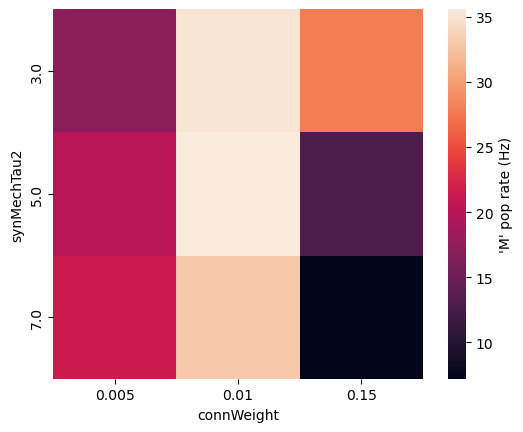

In [4]:
#!pip install pandas
#!pip install seaborn

from analysis import readBatchData, plot2DRate
dataFolder = 'data/'
batchLabel = 'tauWeight'

params, data = readBatchData(dataFolder, batchLabel, loadAll=0, saveAll=1, vars=None, maxCombs=None)
%matplotlib inline
plot2DRate(dataFolder, batchLabel, params, data, 'synMechTau2', 'connWeight', 'M', "'M' pop rate (Hz)")


Running the above cell should produce a color plot showing the relation between the two parameters explored and the firing rate of the M populations. Notice how the rate initially increases as a function of connection weight, but then decreases due to depolarization blockade; and how the effect of the synaptic time decay constant (synMechTau2) depends on whether the cell is spiking normally or in blockade. Batch simulations and analyses facilitate exploration and understanding of these complex interactions.